# Are you Being Served? A Study on the Public Transport Availability in Pittsburgh 

## Introduction

The question we are trying to answer through our project is - are communities being fairly served through public transportation? Transportation is not just moving people from point A to point B. It is also a system that either limits or expands the opportunities available to people based on where they live. There are various indicators for this namely the value of fares, low frequency, distant bus stops, and crowded and unsafe buses. We will use some of these to quantitatively evaluate the public transportation services offered by Port Authority in greater Pittsburgh area.


For solving the above problem, we will mine demographic data from the recent US census and the existing commute services to view shortcomings on a periodic basis in public conveyance. We intend to use economic characteristics like: income, occupation, housing characteristics like: size, density, vehicles owned and commuting characteristics like mode of transport, travel time from the census data and finally establish a relation between the requirement and availability of public transport service in Pittsburgh. The Port Authority data would be scraped from the TrueTime api. The data and results of our analysis would be presented in an interactive map allowing better trend visualization and data exploration.


## Data Sets Used

### Port Authority Data 

1. http://www.portauthority.org/GeneralTransitFeed/
2. http://www.portauthority.org/GeneralTransitFeed/GIS/

The Pittsburgh Port Authority Transport (PAT) provides comprehensive data on the public transport network from the light rail to the buses. From this data we get information about bus and train stops as well as the route information. Even though PAT provides live feeds of the tracking data via their TrueTime portal, we would be using the static version of the data provided by 

### US Census Relationship Data

1. http://pittsburghpa.gov/dcp/gis/gis-data-new
2. http://www.census.gov/geo/maps-data/data/relationship.html

The US Census provides an overwhelming amount of information. We will take the demographics information, which is relevant to our context, like commute preferences based on age and income, population density per tract, travel time and frequency for public transport use, etc. 

## Python Library 

For this project, we would be using GeoPandas, Pandas and Folium for data processing and visualization.

**Folium** is a great *interactive* geospatial visualization python library. Folium builds on the data wrangling strengths of the Python ecosystem and the mapping strengths of the Leaflet.js library. The library has a number of built-in tilesets such as OpenStreetMap.

In [1]:
#import the relevant OSgeo library
from osgeo import gdal
from osgeo import ogr
from osgeo import osr
#import database libraries, pandas, geopandas, folium
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import folium
#useful tools
from IPython.display import HTML
import shapely
from shapely.geometry import Point
import shapely.wkt
import numpy as np
import scipy as sp
import scipy.ndimage
import matplotlib.pyplot as plt
import sys
%matplotlib inline

The data sets are loaded and converted to a common Coordinate Reference System of EPSG4326 (WGS84). Even though the US census datasets and PAT datasets are in the NAD93 CRS, it is easier to use EPSG4326 with Folium

In [2]:
tract_gpd = gpd.GeoDataFrame.from_file('GIS/census_tract/census_tract.shp')
stops_gpd = gpd.GeoDataFrame.from_file('GIS/PAAC_Stops_1609_FinalPublic/PAAC_Stops_1609_FinalPublic.shp')
nearest_stops_gpd = gpd.GeoDataFrame.from_file('GIS/nearest_stops/nearest_stops.shp')
routes_gpd = gpd.GeoDataFrame.from_file('GIS/PAAC_Routes_1609_Final_Public/PAAC_Routes_1609_Final_Public.shp')

tract_gpd = tract_gpd.to_crs(epsg='4326')
stops_gpd = stops_gpd.to_crs(epsg='4326')
nearest_stops_gpd = nearest_stops_gpd.to_crs(epsg='4326')
routes_gpd = routes_gpd.to_crs(epsg='4326')

tract_json = tract_gpd['geometry'].to_json()

### US tract data as common reference

Before the various data processing can be done over the various set of datas, they need to be associated using a common reference or primary key in database vocubulary. This is interesting since there isnt a common field in all the datasets. However all the datasets can be related spatially and plotted on the map. Thus we can use geospatial coordinates to tie the datasets together. 

We will combine the two datasets by linking bus stops to the US census tracts and then using tractId to join the US census data. This primary key is stored as census_tract.shp.


In [ ]:
pitts_map = folium.Map(location=[40.4, -79.9],width=800, height=800, zoom_start=10, tiles='Stamen Toner')
folium.GeoJson(tract_json, 
        style_function=lambda feature:{'weight':1}).add_to(pitts_map)
pitts_map

To get started we delve into the data obtained from Port Authority and analyze the existing public transport service across different tracts in Pittsburgh. The following data obtained from GIS has details about each route, the buses on each route and the spread of the stops. We have plotted the bus stops(shown as circles) on each route along with the tracts through which the buses passes in the following visualization.

In [ ]:
for index,stop in stops_gpd.iterrows():
     folium.CircleMarker( location=[ stop['Latitude'], stop['Longitude'] ], fill_color='#b51500', radius=2 ).add_to(pitts_map)
pitts_map

In [ ]:
print tract_gpd.columns
print tract_gpd.head(5)
print stops_gpd.columns
print nearest_stops_gpd.columns
print routes_gpd.columns

In [ ]:
print stops_gpd.iloc[0]
print nearest_stops_gpd.iloc[0]
print routes_gpd.iloc[100]

In [ ]:
stops_data_gpd = stops_gpd[['CleverID','geometry','Routes_160']].copy(deep=True)

In [ ]:
out_gpd = stops_data_gpd.merge(nearest_stops_gpd[['CleverID','area']], on='CleverID', how='left')

In [ ]:
bus_freq_map = {}
for _,row in routes_gpd.iterrows():
    bus_freq_map[row['ROUTE']] = np.float(row['Avg_Wkdy_F'])

In [ ]:
service = np.zeros(len(out_gpd))
for i, row in out_gpd.iterrows():
    per_bus_str = [s.strip() for s in row['Routes_160'].split(',')]
    per_bus = []
    for pid in per_bus_str:
        if pid in bus_freq_map:
            per_bus.append(bus_freq_map[pid])
        if not pid in bus_freq_map and pid[1:] in bus_freq_map:
            per_bus.append(bus_freq_map[pid[1:]])
    if len(per_bus) != 0: 
        service[i] = np.mean(per_bus)
out_gpd['service'] = pd.Series(service)

After extracing the relevant fields, we can use a spatial join to merge the PAT data with the tract data

In [ ]:
stops_in_tract = sjoin(out_gpd, tract_gpd, how='left',op='within')
grouped_stops = stops_in_tract.groupby('index_right')

In [ ]:
tract_out_gpd = tract_gpd.copy(deep=True)

In [ ]:
N = len(tract_out_gpd)
busstop_count = np.zeros(N)
bus_mean_service = np.zeros(N)
bus_mean_coverage = np.zeros(N)


In [ ]:
for name, group in grouped_stops:
    tract_id = int(name)
    busstop_count[tract_id] = len(group)
    bus_mean_service[tract_id] = np.mean(group['service'])
    bus_mean_coverage[tract_id] = np.mean(group['area'])

In [ ]:
tract_out_gpd['busstop_count'] = pd.Series(busstop_count)
tract_out_gpd['bus_mean_service'] = pd.Series(bus_mean_service)
tract_out_gpd['busstop_mean_coverage'] = pd.Series(bus_mean_coverage)

To draw some conclusions on the availability and service of public transport, we have plotted a relative bus stop count per tract. The following graph plots the number of bus stops (including all routes) vs any tract.

In [ ]:
plt.plot(sorted(busstop_count))

But the above histogram might mislead us, tracts with higher geographical area might tend to have more number of bus stops on an average than smaller tracts. To get a better estimation for availability we use bus stop density - bus stops per area of a tract. The following graph uses darker colours to denote tracts with good bus stop density. 

As we can see in the graph the darkest region is the Pittsburgh downtown.  

In [ ]:
def convert_to_hex(rgba_color) :
    red = str(hex(int(rgba_color[0]*255)))[2:]
    green = str(hex(int(rgba_color[1]*255)))[2:]
    blue = str(hex(int(rgba_color[2]*255)))[2:]

    if blue=='0':
        blue = '00'
    if red=='0':
        red = '00'
    if green=='0':
        green='00'

    return '#'+ red + green + blue

In [ ]:
norm = plt.Normalize()
colors = plt.cm.YlOrRd(norm(busstop_count)) #yellow orange red colors
alpha = np.zeros(len(busstop_count))
for i in range(len(busstop_count)): 
    if busstop_count[i] != 0:
        alpha[i] = 0.5 #set transparency to 0 for 0 tally
colors = [convert_to_hex(c) for c in colors]

In [ ]:
busstop_count_gpd = tract_gpd[['geometry']].copy(deep=True)
busstop_count_gpd['color'] = pd.Series(colors)
busstop_count_gpd['alpha'] = pd.Series(alpha)
busstop_count_gpd['tally'] = pd.Series(busstop_count)
busstop_count_json = busstop_count_gpd.to_json()
busstop_count_map = folium.Map(location=[40.4, -79.9],width=800, height=800, zoom_start=10, tiles='Stamen Toner')
folium.GeoJson(busstop_count_json,
    style_function=lambda feature: {
        'fillColor': feature['properties']['color'],
        'weight' : 1,
        'fillOpacity' : feature['properties']['alpha']
        }).add_to(busstop_count_map)
busstop_count_map

In [ ]:
vis_gpd = tract_gpd[['geometry']].copy(deep=True)
norm = plt.Normalize()
colors = plt.cm.YlOrRd(norm(bus_mean_service)) #yellow orange red colors
colors = [convert_to_hex(c) for c in colors]
vis_gpd['color'] = pd.Series(colors)
routes_vis_json = vis_gpd[['geometry','color']].to_json()

In [ ]:
routes_map = folium.Map(location=[40.4, -79.9],width=800, height=800, zoom_start=10, tiles='Stamen Toner')
folium.GeoJson(routes_vis_json,
    style_function=lambda features: {
        'color': features['properties']['color'],
        'weight' : 2,
        }).add_to(routes_map)
routes_map

As a metric for availability, we decided to calculate minimum service standard where minimum standard requires a service frequency of 20 minutes (or better) during the weekday inter-peak period (about 10 a.m. to 5 p.m.) and 30 minutes (or better) during the day on Saturdays and Sundays on surface routes and 30 minutes (or better) during the weekday inter-peak period in combination with seven-day operation. PA provides something very similar called ‘Avg_Wkdy_F’ in the data for each route. In the visualisation below, we have colour-coded this information to get an idea about minimum service standard in each tract. The tracts which have multiple routes passing through then with high avg_wkdy_f value, the residents in these tracts have better access to public transport

### Analysis of transport stops
To better analyse the influence of transport stops, we use voronoi decomposition of pittsburgh. This map of cells represents the shortest distance to the nearest transport stop. Initutively, the cell is an area which that stop services. 

In [ ]:
folium.GeoJson(nearest_stops_gpd['geometry'].to_json(), 
        style_function=lambda feature:{'weight':1}).add_to(pitts_map)
pitts_map

## Current Status

We have currently explored and presented the insights we have obtained from the Port Authority data. We have a good idea now what all we can use from this data to understand trends. As the next step, we will obtain the minimum service standard metric for each tract and then relate this with the demand in that particular tract. 

# Joined Census Data and Tract Data

In [4]:
def plotFig(file1, file2, file3, file4, file5, file6, columns):
    tract = pd.read_csv(file1)
    census = pd.read_csv(file2)
    population = pd.read_csv(file3)
    earning = pd.read_csv(file4)
    income = pd.read_csv(file5)
    vehicles = pd.read_csv(file6)
    
    census = census.drop(census.index[[0]])
    population = population.drop(population.index[[0]])
    earning = earning.drop(earning.index[[0]])
    income = income.drop(income.index[[0]])
    vehicles = vehicles.drop(vehicles.index[[0]])
    
    tract = tract.rename(columns={'AFFGEOID': 'GEO.id', 'GEOID': 'GEO.id2'})
    tractdf = tract_gpd.rename(columns={'AFFGEOID': 'GEO.id'})
    
    census["GEO.id2"] = census["GEO.id2"].astype(np.int64)
    population["GEO.id2"] = population["GEO.id2"].astype(np.int64)
    census["HD01_VD10"] = census["HD01_VD10"].astype(float)
    census["HD01_VD01"] = census["HD01_VD01"].astype(float)
    census["HD02_VD10"] = census["HD02_VD10"].astype(float)
    census["HD02_VD01"] = census["HD02_VD01"].astype(float)
    
    population["HD01_VD01"] = population["HD01_VD01"].astype(float)
    population["HD02_VD01"] = population["HD02_VD01"].astype(float)
#     income["HC02_EST_VC20"] = income["HC02_EST_VC20"].astype(float)
    
#     earning["HD01_VD02"] = earning["HD01_VD02"].astype(float)
#     earning["HD01_VD05"] = earning["HD01_VD05"].astype(float)
    population = population.rename(columns={'HD01_VD01': 'Count', 'HD02_VD01': 'CountVariance'})
    census = census.rename(columns={'HD01_VD10': 'BusTravelers', 'HD01_VD01': 'Travelers', 'HD02_VD10': 'BusTravelerVariance', 'HD02_VD01':'TravelerVariance'})
    earning = earning.rename(columns={'HD01_VD02': 'MedianEarning', 'HD01_VD05': 'BusTravelersMedianEarning', 'HD02_VD02': 'MedianEarningVariance', 'HD02_VD05': 'BusTravelersMedianEarningVariance'})
    income = income.rename(columns={'HC02_EST_VC20': 'MeanIncome', 'HC02_MOE_VC20': 'MeanIncomeVariance'})
    vehicles = vehicles.rename(columns={'HD01_VD01': 'TotalVehiclesUsed'})
    
#     census["score"] = census["HD01_VD10"]/census["HD01_VD01"] #add some smoothing
#    print census["score"].head()

    merged = tract.merge(census, on=["GEO.id"], how="inner")
    merged = merged.merge(tractdf, on=["GEO.id"], how="inner")
    merged = merged.merge(population, on=["GEO.id"], how="inner")
    merged = merged.merge(earning, on=["GEO.id"], how="inner")
    merged = merged.merge(income, on=["GEO.id"], how="inner")
    merged = merged.merge(vehicles, on=["GEO.id"], how="inner")
    
#     merged["MedianEarning"] = merged["MedianEarning"].astype(float)
#     merged["BusTravelersMedianEarning"] = merged["BusTravelersMedianEarning"].astype(float)

    columns.append("GEO.id")
    features = ["busstop_count", "bus_mean_service", "busstop_mean_coverage"]
    columns.extend(features)
    columns.append("BusTravelers")
    columns.append("Travelers")
    columns.append("ALAND")
    columns.append("Count")
    columns.append("MedianEarning")
    columns.append("BusTravelersMedianEarning")
#     columns.append("MeanIncome")
    columns.append("TotalVehiclesUsed")
    
    columns.append("BusTravelerVariance")
    columns.append("TravelerVariance")
    columns.append("CountVariance")
    columns.append("MedianEarningVariance")
    columns.append("BusTravelersMedianEarningVariance")
    columns.append("MeanIncomeVariance")
    
    result = merged[columns].copy()
    result["ALAND"] = result["ALAND"].astype(float)
#     result["busstop_count"] = result["busstop_count"]/result["ALAND"]
    result["Count"] = result["Count"]#/result["ALAND"]
    result["BusTravelers"] = result["BusTravelers"]#/result["ALAND"]
#     result['busstop_mean_coverage'] = result['busstop_mean_coverage']/result["ALAND"]
    
    result = result.replace('-', np.nan)
    result = result.replace('2,500-', 2500)
    result = result.replace('***', 0)
    result = result.dropna()
    result["MedianEarning"] = result["MedianEarning"].astype(float)
    result["BusTravelersMedianEarning"] = result["BusTravelersMedianEarning"].astype(float)
#     result["MeanIncome"] = result["MeanIncome"].astype(float)
    result["TotalVehiclesUsed"] = result["TotalVehiclesUsed"].astype(float)
    
    result["MedianEarningVariance"] = result["MedianEarningVariance"].astype(float)
    result["BusTravelersMedianEarningVariance"] = result["BusTravelersMedianEarningVariance"].astype(float)
    result["MeanIncomeVariance"] = result["MeanIncomeVariance"].astype(float)
    result["BusTravelerVariance"] = result["BusTravelerVariance"].astype(float)
    result["TravelerVariance"] = result["TravelerVariance"].astype(float)
    result["CountVariance"] = result["CountVariance"].astype(float)
    
#     print result.head()
    return result[columns[1:11]].copy(), result.copy()

In [5]:
tract_file = "bus_to_tract.csv"
featurefile = "Census Data/ACS_14_5YR_B08006_with_ann.csv"
populationfile = "Census Data/ACS_14_5YR_B01003_with_ann.csv"
earningfile = "Census Data/ACS_14_5YR_B08121_with_ann.csv"
meanincomefile = "Census Data/ACS_14_5YR_S1902_with_ann.csv"
vehiclesfile = "Census Data/ACS_14_5YR_B08015_with_ann.csv"
columns = []
result, result_v = plotFig(tract_file, featurefile, populationfile, earningfile, meanincomefile, vehiclesfile, columns)
# print result.dtypes
# print result.columns
print result.head()

   busstop_count  bus_mean_service  busstop_mean_coverage  BusTravelers  \
0           30.0       2864.183333           39195.666667         226.0   
1           17.0       2652.282353           29753.882353         229.0   
2           11.0       2308.818182           71906.363636         315.0   
3            9.0       3027.222222           33853.333333         193.0   
4           15.0       3274.200000           49114.266667         244.0   

   Travelers     ALAND   Count  MedianEarning  BusTravelersMedianEarning  \
0      626.0  790374.0  1685.0        27500.0                    14453.0   
1     1415.0  404921.0  2078.0        31747.0                    33583.0   
2     1642.0  446354.0  2790.0        35667.0                    35074.0   
3      431.0  327621.0  1304.0        26250.0                    24821.0   
4     1039.0  754718.0  1783.0        39205.0                    32375.0   

   TotalVehiclesUsed  
0              290.0  
1              665.0  
2              840.0  


In [24]:
#Get intersection
def getOverlap(a, b):
    return max(0, min(a[1], b[1]) - max(a[0], b[0]))

df_v = result_v.copy()
factor = 1
df_v["IncomeRange"] = list(zip(df_v['MedianEarning'] - factor*df_v['MedianEarningVariance'], df_v['MedianEarning'] + factor*df_v['MedianEarningVariance']))
df_v["BusIncomeRange"] = list(zip(df_v['BusTravelersMedianEarning'] - factor*df_v['BusTravelersMedianEarningVariance'], df_v['BusTravelersMedianEarning'] + factor*df_v['BusTravelersMedianEarningVariance']))
# df_v["IncomeOverlap"] = df_v[["IncomeRange", "BusIncomeRange"]].apply(getOverlap, axis=1)
df_v["IncomeOverlap"] = df_v.apply(lambda row: getOverlap(row['IncomeRange'], row['BusIncomeRange']), axis=1)

print df_v["IncomeOverlap"].describe()
bus_normal = np.where(df_v['BusTravelersMedianEarning'].values <= df_v['MedianEarning'].values)
pframe = df_v.iloc[bus_normal]
# print pframe['GEO.id']

full_frame = pd.read_csv(earningfile)

full_frame = full_frame.merge(pframe, on=["GEO.id"], how="inner")
ids_bus_more_regular =  full_frame["GEO.display-label"].apply(lambda x: x[13:x.index(",")])

ids_bus_more_regular.to_csv("tract_ids_regular_income_more.csv")
    

# plt.plot(df_v['IncomeOverlap'].values);
# plt.show()

# print df_v.iloc[[18]
# print df_v.head()

count      354.000000
mean      8346.296610
std       5567.506562
min          0.000000
25%       4688.000000
50%       7604.000000
75%      11605.500000
max      30364.000000
Name: IncomeOverlap, dtype: float64


In [ ]:
from numpy import corrcoef, sum, log, arange
from numpy.random import rand
from pylab import pcolor, show, colorbar, xticks, yticks
from scipy import stats
# generating some uncorrelated data
data = result.as_matrix().transpose() # each row of represents a variable

# print data.shape

# creating correlation between the variables
# variable 2 is correlated with all the other variables
# data[2,:] = sum(data,0)
# variable 4 is correlated with variable 8
# data[4,:] = log(data[8,:])*0.5

# plotting the correlation matrix
R = corrcoef(data)
print R
pcolor(R)
colorbar()
yticks(arange(0.5,10.5),range(0,10))
xticks(arange(0.5,10.5),range(0,10))
show()

354 10


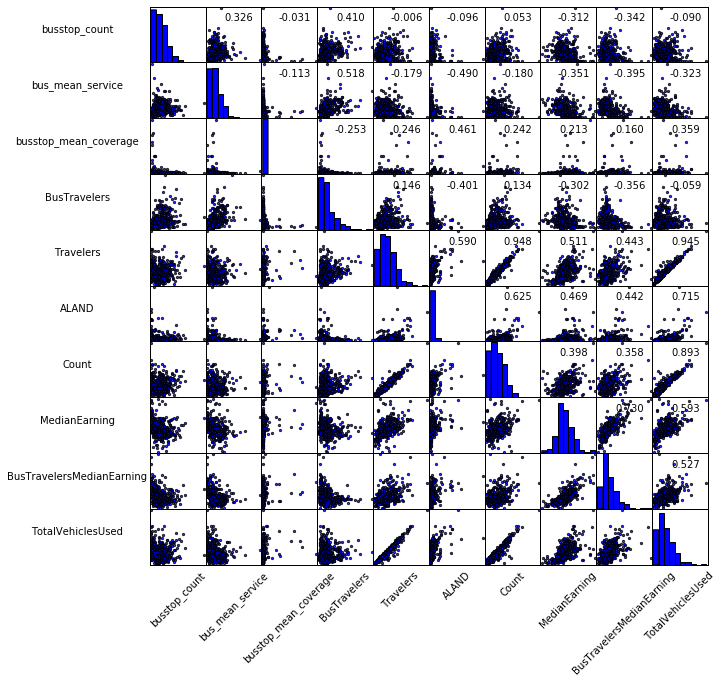

NameError: name 'savefig' is not defined

In [6]:
from pandas.tools.plotting import scatter_matrix
data = result.as_matrix()

m,n = result.shape
print m,n
sm = scatter_matrix(result, figsize = (n,n), alpha=0.8)
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
[s.get_yaxis().set_label_coords(-1.30,0.5) for s in sm.reshape(-1)]

[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

corr = result.corr(method = 'spearman').as_matrix()
for i, j in zip(*plt.np.triu_indices_from(sm, k=1)):
    sm[i, j].annotate("%.3f" %corr[i,j], (0.6, 0.8), xycoords='axes fraction', ha='center', va='center')
    
plt.show()
  
# savefig('foo.png')

(array([ 16,  49, 129, 130, 185, 255, 297, 316, 334], dtype=int64),)
(array([  5,  60,  98, 106, 135, 182, 242, 248, 249, 289, 314], dtype=int64),)


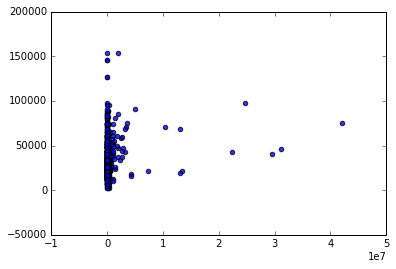

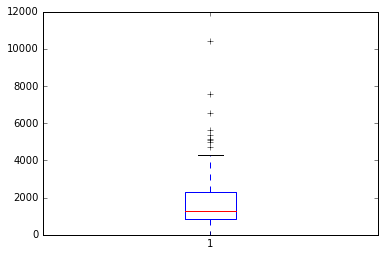

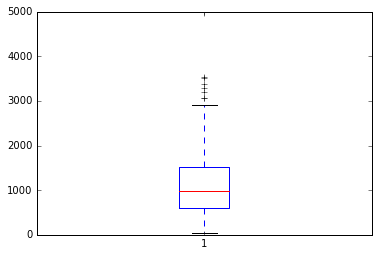

count     354.000000
mean     1128.714689
std       730.731308
min        45.000000
25%       600.000000
50%       970.000000
75%      1528.750000
max      4990.000000
Name: TotalVehiclesUsed, dtype: float64

In [7]:
import matplotlib.pyplot as plt
# print result['bus_mean_service'].values


plt.scatter(result['busstop_mean_coverage'].values, result['BusTravelersMedianEarning'].values, alpha=0.8)
threshold = 10000000
print np.where(result['busstop_mean_coverage'].values > threshold )

plt.scatter(result['bus_mean_service'].values, result['BusTravelersMedianEarning'].values, alpha=0.8)
threshold = 4000
print np.where(result['bus_mean_service'].values > threshold )
plt.show()

plt.boxplot(result['bus_mean_service'].values)
plt.show()
result['bus_mean_service'].describe()

plt.boxplot(result['TotalVehiclesUsed'].values)
plt.show()
result['TotalVehiclesUsed'].describe()



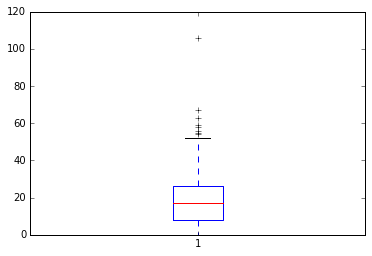

count    355.000000
mean      18.757746
std       14.474717
min        0.000000
25%        8.000000
50%       17.000000
75%       26.000000
max      106.000000
Name: busstop_count, dtype: float64

In [28]:
plt.boxplot(result['busstop_count'].values)
plt.show()
result['busstop_count'].describe()

In [ ]:
print result.columns

plt.boxplot(result['busstop_count'].values)
plt.show()
result['busstop_count'].describe()

busstop_count                       1.0
bus_mean_service                  906.0
busstop_mean_coverage        29474635.0
BusTravelers                       43.0
Travelers                        2718.0
ALAND                         9558163.0
Count                            4586.0
MedianEarning                   35860.0
BusTravelersMedianEarning       40673.0
TotalVehiclesUsed                2160.0
Name: 143, dtype: float64


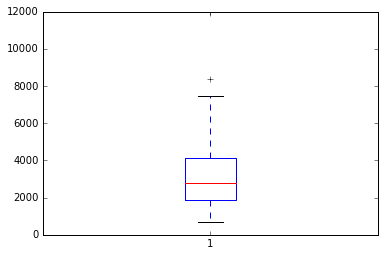

KeyError: 'GEO.id'

In [17]:
print result.iloc[129]

plt.boxplot(result['Count'].values)
plt.show()
result['Count'].describe()

result.loc[result['GEO.id'] == "1400000US42003486700"]